In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import gensim
import regex as re

In [2]:
%matplotlib inline

## q1: weighted average in numpy

- implement a weighted average calculation in pure numpy

In [3]:
def q1(values, weights):
    """Return the weighted average of values weighted by weights.
    
    Inputs:
        values -> numpy array
        weights -> numpy array
    Returns:
        weighted_average -> scalar
    """
    return (values * weights).sum()

In [4]:
values, weights = np.array([0.3, 0.5, 0.3]), np.array([0.2, 0.6, 0.2])
weighted_average = 0.42

assert np.isclose(q1(values, weights), weighted_average)

## q2: basic tokenizer

- implement a basic tokenizer in pure python
- it has to
  - lowercase everything
  - remove everything except the 26 standard letters in the English alphabet using a regular expression
  - remove the defined stopwords
  - lemmatize according to the given list of lemmas

In [5]:
def q2(text, stopwords, lemmas):
    """Return a list of tokens, remove non-alphabet-characters, remove stopwords, lemmatize.
    
    Inputs:
        text -> string
        stopwords -> string of whitespace separated stopwords
        lemmas -> string of line and whitespace separated lemmas
    Returns:
        tokens -> list of tokens
    """    
    # lowercase text, remove non-alphabet characters, and split on whitespace
    alpha = re.sub(r'[^a-zA-Z ]', '', text.lower()).split()
    
    # define lemmatization dictionary
    lemma_dict = dict(x.split() for x in lemmas.split('\n'))
    
    # lemmatize alpha
    lemmatized = [lemma_dict[x] if x in lemma_dict.keys() else x for x in alpha]
    
    # remove stopwords
    stops_removed = [x for x in lemmatized if x not in stopwords.split()]
    
    return stops_removed

In [6]:
text = "This is the greatest day. It is 27°C outside. It could not get better."
stopwords = "this be the not a it could"
lemmas = """greatest great
better good
is be"""
tokens = ['great', 'day', 'c', 'outside', 'get', 'good']

assert q2(text, stopwords, lemmas) == tokens

## q3: load the latest numberbatch word embedding model using gensim

- download the latest numberbatch word embedding model at
https://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-en-17.06.txt.gz

- then import it using gensim

In [7]:
def q3(model_path):
    """Return numberbatch embedding model loaded using gensim.
    
    Inputs:
        model_path -> path to the .txt format numberbatch embedding model
    Returns:
        model -> gensim embedding model
    """
    return gensim.models.KeyedVectors.load_word2vec_format(model_path)

In [8]:
model = q3("numberbatch-en.txt")

In [9]:
assert len(model.vocab) == 417194
assert len(model['the']) == 300

## q4: return a pandas dataframe with the 100 words and cosine similarity scores most closely related to the word 'innovation' in the model, also add a column with the cosine similarity score divided into quartiles

- the df should have 3 columns
1. 'word' containing the top 100 related words to 'innovation'
2. 'score' containing the cosine similarity scores of the words
3. 'score_quartile' containing the quartiles for the 'score' column
    - labeling as ints 1-4 (1 is highest score quarter, 4 is lowest score quarter)

In [10]:
def q4(model):
    """Return scores_df with a 'quartile' column added, partitioning the scores into 4 quartiles.
    
    Inputs:
        model -> the loaded numberbatch word embedding model
    Returns:
        df -> the pandas dataframe with the described 3 columns 'word', 'score', 'score_quartile'
    """    
    # define Pandas df with 100 words most similar to innovation
    scores_df = pd.DataFrame(model.most_similar('innovation', topn=100), columns = ['word', 'score'])
    
    # calculate quartile ranks
    scores_df['score_quartile'] = pd.qcut(scores_df['score'], 4, labels = [4, 3, 2, 1]).astype(int)
    
    return scores_df

In [11]:
q4_df = q4(model)

assert list(q4_df['word'])[0] == 'innovationist'
assert list(q4_df['word'])[-1] == 'tech_head'

/Users/piocalderon/anaconda/lib/python3.6/site-packages/gensim/models/keyedvectors.py:932: RuntimeWarning: invalid value encountered in true_divide
  self.vectors_norm = (self.vectors / sqrt((self.vectors ** 2).sum(-1))[..., newaxis]).astype(REAL)


## q5: cosine similarity

- implement a cosine similarity (i.e. bounded between -1 and 1) score function using only numpy

In [12]:
def q5(vec1, vec2):
    """Return cosine similarity between vec1 and vec2.
    
    Inputs:
        vec1, vec2 -> 1d numpy arrays of same length
    Returns:
        cos_similarity -> cosine similarity between vec1 and vec2
    """   
    cos_similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    
    return cos_similarity

In [13]:
assert np.isclose(q5(model['innovation'], model['innovationist']), 0.92195)

## q6: add a column and sort 

- to the returned df from q4, add a new column 'responsibility' scoring all the words in q4_df with their cosine similarity to the word 'responsible' in the model
- use q5 as the cosine similarity function
- sort by that new column in descending order
- don't alter the original q4_df dataframe

In [14]:
def q6(df, model, cos_similarity):
    """Return a new df with the the new column as described and also sorted by that new column.
    
    Inputs:
        df -> q4_df
        model -> the loaded numberbatch word embedding model
        cos_similarity -> function, the cos similarity function from q5
    Returns:
        df -> q4_df copy with new columns and sorted by that new column
    """
    
    df['responsibility'] = df['word'].map(lambda x: cos_similarity(model[x], model['responsibility']))
    df = df.sort_values('responsibility', ascending = False)
    
    return df

In [15]:
q6_df = q6(q4_df, model, q5)

assert list(q6_df['word'])[0] == 'initiative'
assert np.isclose(list(q6_df['responsibility'])[0], 0.17459)

## q7 groupby and bar plot

- group q6_df by the 'score_quartile' column and based on that produce a bar plot that of the mean value of the 'responsibility' column in the 4 categories of the 'score_quartile'
- (i.e. this will be a bar graph with 4 bars, x axis being the 'score_quartile' and y being the mean value of the 'responsibility' column)

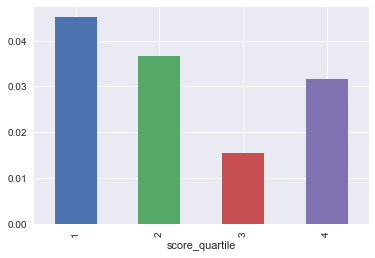

In [16]:
q6_df.groupby('score_quartile')['responsibility'].mean().plot.bar()

## q8 scatterplot and some optical improvements

- produce a dot scatterplot of the columns 'score' (x axis) and 'responsibility' (y axis) from q6_df
- scale the scatter dots by 10 times the value of column 'score_quartile' respectively
- use seaborn to remove the right and top axis in the graph

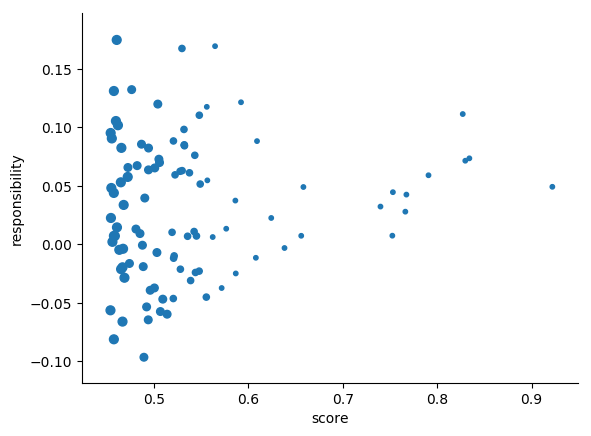

In [19]:
# Lower score_quartile -> Higher score -> Smaller circle
q6_df.plot.scatter('score', 'responsibility', s = 10 * q6_df['score_quartile'])

# Despining the right and top axes of the default seaborn theme doesn't do anything since it's already 'despined'
# Let's reset the theme to Matplotlib's default theme first.
sns.reset_orig()
# Then we despine.
sns.despine()